In [1]:
import numpy as np
import pandas as pd
import re as re
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Importing Data

#### About Dataset
Context

This data set contains information on user preference data from 73,515 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

Content

#### Anime.csv

    anime_id - myanimelist.net's unique id identifying an anime.
    name - full name of anime.
    genre - comma separated list of genres for this anime.
    type - movie, TV, OVA, etc.
    episodes - how many episodes in this show. (1 if movie).
    rating - average rating out of 10 for this anime.
    members - number of community members that are in this anime's "group".

#### Rating.csv

    user_id - non identifiable randomly generated user id.
    anime_id - the anime that this user has rated.
    rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [2]:
anime = pd.read_csv('Anime/anime.csv')
ratings = pd.read_csv('Anime/rating.csv')

In [3]:
anime.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [4]:
ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

# Data Exploration

In [5]:
anime.shape

(12294, 7)

In [6]:
anime['anime_id'].nunique()

12294

In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
anime.describe(include= 'all')

anime_id                     name   genre   type episodes  \
count   12294.000000                    12294   12232  12269    12294   
unique           NaN                    12292    3264      6      187   
top              NaN  Shi Wan Ge Leng Xiaohua  Hentai     TV        1   
freq             NaN                        2     823   3787     5677   
mean    14058.221653                      NaN     NaN    NaN      NaN   
std     11455.294701                      NaN     NaN    NaN      NaN   
min         1.000000                      NaN     NaN    NaN      NaN   
25%      3484.250000                      NaN     NaN    NaN      NaN   
50%     10260.500000                      NaN     NaN    NaN      NaN   
75%     24794.500000                      NaN     NaN    NaN      NaN   
max     34527.000000                      NaN     NaN    NaN      NaN   

              rating       members  
count   12064.000000  1.229400e+04  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean        6.473902  1.807134e+04  
std         1.026746  5.482068e+04  
min         1.670000  5.000000e+00  
25%         5.880000  2.250000e+02  
50%         6.570000  1.550000e+03  
75%         7.180000  9.437000e+03  
max        10.000000  1.013917e+06

In [9]:
anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [10]:
anime['name'].nunique()

12292

In [11]:
anime['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

In [12]:
anime['type'].value_counts(normalize= True)

TV         0.308664
OVA        0.269867
Movie      0.191377
Special    0.136604
ONA        0.053713
Music      0.039775
Name: type, dtype: float64

In [13]:
anime.sort_values(by= 'rating', ascending= False).head(10)

anime_id                                     name  \
10464     33662  Taka no Tsume 8: Yoshida-kun no X-Files   
10400     30120              Spoon-hime no Swing Kitchen   
9595      23005                         Mogura no Motoro   
0         32281                           Kimi no Na wa.   
9078      33607                             Kahei no Umi   
1          5114         Fullmetal Alchemist: Brotherhood   
2         28977                                 Gintama°   
10786     26313          Yakusoku: Africa Mizu to Midori   
3          9253                              Steins;Gate   
4          9969                            Gintama&#039;   

                                                   genre   type episodes  \
10464                                     Comedy, Parody  Movie        1   
10400                                    Adventure, Kids     TV  Unknown   
9595                                       Slice of Life  Movie        1   
0                   Drama, Romance, School, Supernatural  Movie        1   
9078                                          Historical  Movie        1   
1      Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64   
2      Action, Comedy, Historical, Parody, Samurai, S...     TV       51   
10786                                        Drama, Kids    OVA        1   
3                                       Sci-Fi, Thriller     TV       24   
4      Action, Comedy, Historical, Parody, Samurai, S...     TV       51   

       rating  members  
10464   10.00       13  
10400    9.60       47  
9595     9.50       62  
0        9.37   200630  
9078     9.33       44  
1        9.26   793665  
2        9.25   114262  
10786    9.25       53  
3        9.17   673572  
4        9.16   151266

In [14]:
anime[anime['name']== 'One Punch Man']

anime_id           name  \
23     30276  One Punch Man   

                                                genre type episodes  rating  \
23  Action, Comedy, Parody, Sci-Fi, Seinen, Super ...   TV       12    8.82   

    members  
23   552458

In [15]:
ratings.shape

(7813737, 3)

In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [17]:
ratings.describe()

user_id      anime_id        rating
count  7.813737e+06  7.813737e+06  7.813737e+06
mean   3.672796e+04  8.909072e+03  6.144030e+00
std    2.099795e+04  8.883950e+03  3.727800e+00
min    1.000000e+00  1.000000e+00 -1.000000e+00
25%    1.897400e+04  1.240000e+03  6.000000e+00
50%    3.679100e+04  6.213000e+03  7.000000e+00
75%    5.475700e+04  1.409300e+04  9.000000e+00
max    7.351600e+04  3.451900e+04  1.000000e+01

In [18]:
ratings.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
ratings['user_id'].nunique()

73515

In [20]:
ratings['anime_id'].nunique()

11200

In [21]:
ratings['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

In [22]:
ratings[(ratings['rating']==-1) & (ratings['user_id']==1) ]

user_id  anime_id  rating
0          1        20      -1
1          1        24      -1
2          1        79      -1
3          1       226      -1
4          1       241      -1
..       ...       ...     ...
148        1     30015      -1
149        1     30296      -1
150        1     30544      -1
151        1     31338      -1
152        1     31845      -1

[149 rows x 3 columns]

In [23]:
pd.set_option('display.max_rows',11400)
anime[~anime['name'].str.isalnum()]

anime_id                                               name  \
0         32281                                     Kimi no Na wa.   
1          5114                   Fullmetal Alchemist: Brotherhood   
2         28977                                           Gintama°   
3          9253                                        Steins;Gate   
4          9969                                      Gintama&#039;   
5         32935  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   
6         11061                             Hunter x Hunter (2011)   
7           820                               Ginga Eiyuu Densetsu   
8         15335  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
9         15417                           Gintama&#039;: Enchousen   
10         4181                               Clannad: After Story   
11        28851                                     Koe no Katachi   
13         2904                 Code Geass: Hangyaku no Lelouch R2   
14        28891                            Haikyuu!! Second Season   
15          199                      Sen to Chihiro no Kamikakushi   
16        23273                            Shigatsu wa Kimi no Uso   
17        24701                      Mushishi Zoku Shou 2nd Season   
18        12355                       Ookami Kodomo no Ame to Yuki   
19         1575                    Code Geass: Hangyaku no Lelouch   
20          263                                     Hajime no Ippo   
21           44  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   
22            1                                       Cowboy Bebop   
23        30276                                      One Punch Man   
24          164                                      Mononoke Hime   
25         7311                      Suzumiya Haruhi no Shoushitsu   
26        17074                   Monogatari Series: Second Season   
27        21939                                 Mushishi Zoku Shou   
29         2001                         Tengen Toppa Gurren Lagann   
30          245                              Great Teacher Onizuka   
31        32983                              Natsume Yuujinchou Go   
32         5258                     Hajime no Ippo: New Challenger   
33        28957                Mushishi Zoku Shou: Suzu no Shizuku   
34        11665                             Natsume Yuujinchou Shi   
35          431                                Howl no Ugoku Shiro   
36        11741                               Fate/Zero 2nd Season   
37        31757                    Kizumonogatari II: Nekketsu-hen   
39        12365                                Bakuman. 3rd Season   
40         1535                                         Death Note   
41        32366                         Gintama°: Aizome Kaori-hen   
42        30654                 Ansatsu Kyoushitsu (TV) 2nd Season   
43        20583                                          Haikyuu!!   
44        19647                             Hajime no Ippo: Rising   
45         4282                     Kara no Kyoukai 5: Mujun Rasen   
46        10379                             Natsume Yuujinchou San   
47        22135                            Ping Pong The Animation   
48        21329                       Mushishi Special: Hihamukage   
49        31043                            Boku dake ga Inai Machi   
50         7785                             Yojouhan Shinwa Taikei   
51         3297                               Aria The Origination   
52        30709                   Kamisama Hajimemashita: Kako-hen   
53         6114                Rainbow: Nisha Rokubou no Shichinin   
54        31240              Re:Zero kara Hajimeru Isekai Seikatsu   
55         4565       Tengen Toppa Gurren Lagann Movie: Lagann-hen   
56         5300                            Zoku Natsume Yuujinchou   
57         9989  Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...   
58        24415                        Kuroko no Basket 3rd Season   
59        11577  

In [24]:
pd.reset_option('display.max_rows')

From the above list we can see that there are few non alpha neumeric characters in name.
This needs to be corrected.

Below are the few of the corrections required to be made.
The brackets indicates the desired changes.

# Data Handling

In [25]:
anime.dropna(inplace= True)
anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [26]:
anime.shape

(12017, 7)

In [28]:
#Cleaning anime names
def name_cleaning(name):
    name = re.sub("&#039;s",  "'s'", name)
    name = re.sub("&#039;",   "",    name)
    name = re.sub("A&#039;s", "",    name)
    name = re.sub("&amp",     "&",   name)
    name = re.sub("°",        "",    name)
    name = re.sub("★",        "",    name)
    name = re.sub("☆",        "",    name)
    name = re.sub("Ψ",        "psi", name)
    name = re.sub("◎",        "",    name)
    name = re.sub(".hack//",  "",    name)
    name = re.sub("&quot",    "",    name)
    name = re.sub("I&#039;",  "",    name)
    name = re.sub("♥",        "",    name)
    name = re.sub("♪",        "",    name)
    
    return name

In [29]:
anime['name'] = anime['name'].apply(name_cleaning)

In [30]:
anime[anime['anime_id']==28977]

anime_id     name                                              genre type  \
2     28977  Gintama  Action, Comedy, Historical, Parody, Samurai, S...   TV   

  episodes  rating  members  
2       51    9.25   114262

In [31]:
anime[anime['anime_id']==15417]

anime_id                name  \
9     15417  Gintama: Enchousen   

                                               genre type episodes  rating  \
9  Action, Comedy, Historical, Parody, Samurai, S...   TV       13    9.11   

   members  
9    81109

#### -1 rating in ratings table
As we have seen above there are few -1 ratings for the users who watched it but didn't rate it

In [32]:
ratings['rating'].replace(-1, np.nan, inplace= True)

In [33]:
ratings.isna().sum()

user_id           0
anime_id          0
rating      1476496
dtype: int64

In [34]:
ratings.dropna(inplace= True)
ratings.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

# Merging

In [35]:
anime = pd.merge(anime,ratings, on= 'anime_id')

In [36]:
anime.rename(columns= {'rating_x':'ratings','rating_y':'user_rating'}, inplace= True)

In [37]:
anime.head()

anime_id            name                                 genre   type  \
0     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
1     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
2     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
3     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
4     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   

  episodes  ratings  members  user_id  user_rating  
0        1     9.37   200630       99          5.0  
1        1     9.37   200630      152         10.0  
2        1     9.37   200630      244         10.0  
3        1     9.37   200630      271         10.0  
4        1     9.37   200630      322         10.0

# Visualisations

#### 1. Univariate

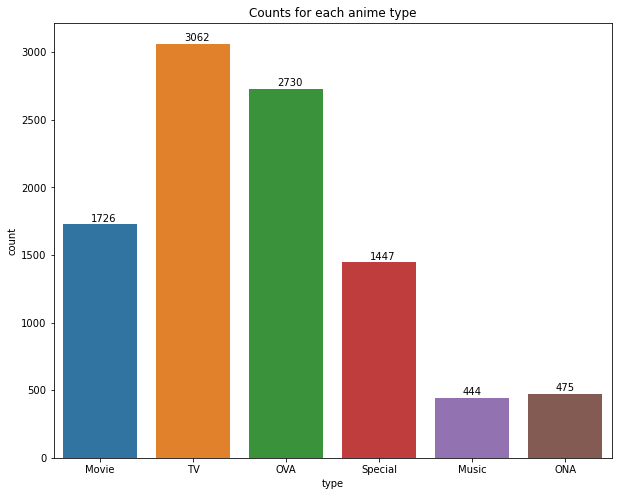

In [38]:
plt.figure(figsize= (10,8))
ax = sns.countplot(x='type', data= anime.drop_duplicates(subset=['name']))
plt.title('Counts for each anime type')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2 - 0.1, height + 20, height)

Text(0.5, 1.0, 'Distribution of anime ratings')

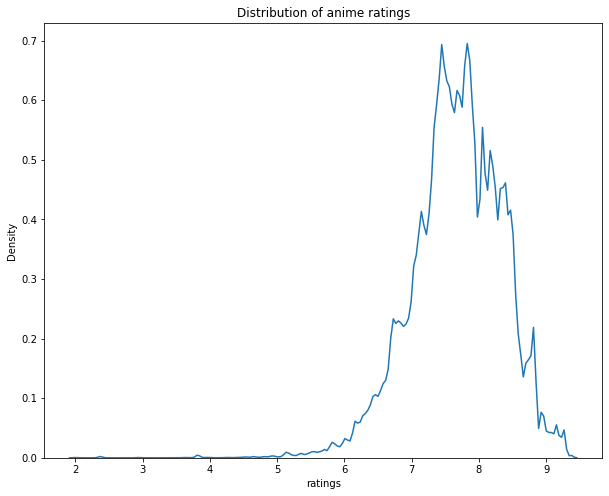

In [39]:
plt.figure(figsize=(10,8))
sns.kdeplot('ratings', data= anime)
plt.title('Distribution of anime ratings')

Text(0.5, 1.0, 'Distribution of user ratings')

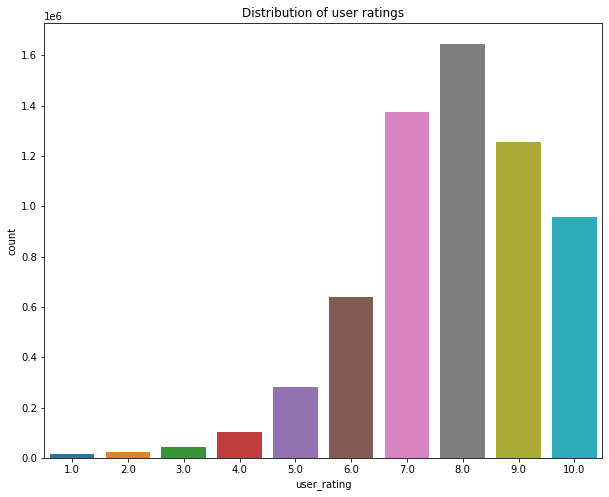

In [40]:
plt.figure(figsize=(10,8))
sns.countplot('user_rating', data= anime,)
plt.title('Distribution of user ratings')

In [41]:
#Users who gave highest count of ratings
top_user = pd.DataFrame(anime.groupby('user_id')['user_rating'].count().sort_values(ascending = False).head(10)).\
reset_index()
top_user.rename(columns={'user_rating':'user_ratings_count'}, inplace= True)
print(top_user)

   user_id  user_ratings_count
0    42635                3747
1    53698                2905
2    57620                2689
3    59643                2632
4    51693                2620
5    45659                2462
6     7345                2429
7    12431                2330
8    65840                2215
9    22434                1990


#### 2. Multivariate

#### Top rated anime by website ratings

In [42]:
anime[['name','ratings']].groupby('name')['ratings'].mean().sort_values(ascending = False).head(10)

name
Kimi no Na wa.                                               9.370000
Fullmetal Alchemist: Brotherhood                             9.260000
Steins;Gate                                                  9.170000
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    9.150000
Hunter x Hunter (2011)                                       9.130000
Gintama                                                      9.112754
Gintama: Enchousen                                           9.110000
Ginga Eiyuu Densetsu                                         9.110000
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare          9.100000
Clannad: After Story                                         9.060000
Name: ratings, dtype: float64

#### Top rated anime based on user ratings

In [43]:
#top rated anime based on user ratings
top_user_anime_36 = pd.DataFrame(anime[['name','user_rating']].groupby('name')['user_rating'].mean().\
                              sort_values(ascending = False).head(36)).reset_index()

#rating count for each anime by user
anime_user_rating_count = pd.DataFrame(anime[['name','user_rating']].groupby('name')['user_rating'].count().\
                                       sort_values(ascending = False)).reset_index()
anime_user_rating_count.rename(columns={'user_rating':'count'}, inplace= True)

#merge
pd.merge(top_user_anime_36, anime_user_rating_count, on= 'name')

name  user_rating  count
0           Sekai Meisaku Douwa: Wow! Maerchen Oukoku         10.0      2
1                        Only You: Viva! Cabaret Club         10.0      1
2                                       Play Ball 2nd         10.0      1
3                             Mak Dau Xiang Dang Dang         10.0      1
4   Kawasaki Frontale x Tentai Senshi Sunred 2nd S...         10.0      1
5                                  McDull, the Alumni         10.0      1
6             Yokohama Meibutsu: Otoko Katayama-gumi!         10.0      1
7                                 Yattokame Tanteidan         10.0      1
8                                             Robotan         10.0      1
9                                          Shiroi Zou         10.0      1
10  Konna Watashitachi ga Nariyuki de Heroine ni N...         10.0      1
11                  Warui no wo Taose!! Salaryman Man         10.0      1
12                          Gozonji! Gekkou Kamen-kun         10.0      1
13                         STAR BEAT!: Hoshi no Kodou         10.0      1
14                   Asari-chan: Ai no Marchen Shoujo         10.0      1
15         Chogattai Majutsu Robot Ginguiser Specials         10.0      1
16                                           Ketsuinu         10.0      1
17                                            Dededen         10.0      1
18                                 Choegang Top Plate         10.0      1
19         Kanagatari. Kanabakari.: Kanadian Families         10.0      1
20                              Ryoujoku Joshi Gakuen         10.0      1
21                                     ShakotanBoogie         10.0      1
22                                     Mak Dau Goo Si         10.0      1
23                      Hello Kitty no Mahou no Ringo         10.0      1
24                                       Hamster Club         10.0      1
25    Kero Kero Keroppi no Kero Kero House no Himitsu         10.0      1
26                     Trapp Ikka Monogatari Specials         10.0      1
27                                  Takoyaki Mant-Man         10.0      1
28                     Midoriyama Koukou Koushien-hen         10.0      1
29                     Hello Kitty no Tomatta Big Ben         10.0      1
30                              What's' Michael? (TV)         10.0      1
31                Hello Kitty no Yappari Mama ga Suki         10.0      1
32           Kamiusagi Rope x Panasonic Collaboration         10.0      1
33                                      Ajisai no Uta         10.0      1
34                Hello Kitty no Circus ga Yatte Kita         10.0      1
35                          Kono Sekai no Katasumi ni          9.5      2

We can see there is quite a list of anime with 10 user ratings

But we can also see that the count of ratings for these anime is mostly 1

These cannot be treated as reliable ratings

So we need to give a threshold number of ratings for each anime

In [65]:
#top rated anime based on user ratings
top_user_anime_36 = pd.DataFrame(anime[['name','user_rating']].groupby('name')['user_rating'].mean().\
                              sort_values(ascending = False)).reset_index()

#rating count for each anime by user
anime_user_rating_count = pd.DataFrame(anime[['name','user_rating']].groupby('name')['user_rating'].count().\
                                       sort_values(ascending = False)).reset_index()
anime_user_rating_count.rename(columns={'user_rating':'count'}, inplace= True)
#selecting only those anime ratings which have count > 10
anime_user_rating_count = anime_user_rating_count[anime_user_rating_count['count']>10]

#merge
pd.merge(top_user_anime_36, anime_user_rating_count, on= 'name').head(10)

name  user_rating  count
0                                     Kimi no Na wa.     9.426313   1961
1                               Ginga Eiyuu Densetsu     9.389788    803
2                   Fullmetal Alchemist: Brotherhood     9.322741  21494
3                                            Gintama     9.279094   8567
4                                        Steins;Gate     9.261326  17151
5                             Hunter x Hunter (2011)     9.234586   7477
6                                 Gintama: Enchousen     9.202258   2126
7  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...     9.191430   2147
8  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...     9.171484   1038
9                               Clannad: After Story     9.165292  15518

Now we can see the top 10 anime by user ratings is now comparable with website ratings

In [74]:
rating = pd.DataFrame(anime[['name','ratings']].groupby('name')['ratings'].mean().sort_values(ascending = False)).\
        reset_index()

top_user_anime = pd.DataFrame(anime[['name','user_rating']].groupby('name')['user_rating'].mean().\
                              sort_values(ascending = False)).reset_index()

difference_rating = pd.merge(rating, top_user_anime, on= 'name')
#taking only those anime with user rating count > 10
difference_rating = pd.merge(difference_rating, anime_user_rating_count, on= 'name')
difference_rating['Difference'] = np.abs(difference_rating['ratings'] - difference_rating['user_rating'])

In [73]:
difference_rating.sort_values('Difference', ascending= False).head(10)

name  ratings  user_rating  \
4163  Crayon Shin-chan Movie 16: Chou Arashi wo Yobu...     6.77     8.214286   
7047                  Kago Shintarou Anime Sakuhin Shuu     5.23     6.588235   
5397                                  Duel Masters Zero     6.40     5.071429   
7207                                 Red Colored Bridge     3.90     2.636364   
5551                            Ana no Oku no Ii Tokoro     6.35     7.600000   
4831                   Love Live! Kouhaku Special Anime     6.59     5.363636   
5569                                        Galo Sengen     6.34     7.538462   
2833                                  Onegai! Samia Don     7.14     8.312500   
6748                                       Good Morning     5.68     6.840000   
7150                                       Pinky Street     4.78     5.882353   

      count  Difference  
4163     14    1.444286  
7047     17    1.358235  
5397     14    1.328571  
7207     11    1.263636  
5551     20    1.250000  
4831     11    1.226364  
5569     13    1.198462  
2833     16    1.172500  
6748     25    1.160000  
7150     17    1.102353

#### Anime where there is highest difference between website raitings and user ratings

In [46]:
genre_count = defaultdict(int)

for genre in anime.genre:
    for g in genre.split(','):
        genre_count[g.strip()] += 1

In [47]:
genre_count

defaultdict(int,
            {'Drama': 1727683,
             'Romance': 2031673,
             'School': 1540798,
             'Supernatural': 1612457,
             'Action': 2663843,
             'Adventure': 1365199,
             'Fantasy': 1629076,
             'Magic': 620772,
             'Military': 364852,
             'Shounen': 1514012,
             'Comedy': 3150030,
             'Historical': 308090,
             'Parody': 226391,
             'Samurai': 96808,
             'Sci-Fi': 1319449,
             'Thriller': 296565,
             'Sports': 195205,
             'Super Power': 634427,
             'Space': 146326,
             'Slice of Life': 906012,
             'Mecha': 462935,
             'Music': 165082,
             'Mystery': 744603,
             'Seinen': 620772,
             'Martial Arts': 211545,
             'Vampire': 185773,
             'Shoujo': 393190,
             'Horror': 364071,
             'Police': 139901,
             'Psychological': 475923,
 

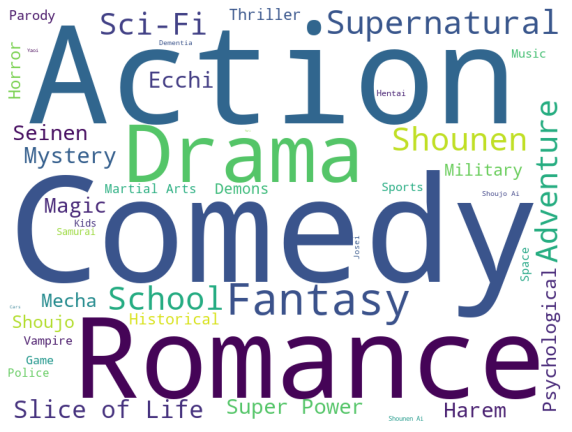

In [48]:
genres_cloud = WordCloud(width=800, height=600, background_color='white').\
generate_from_frequencies(genre_count)

plt.figure(figsize=(10,8))
plt.imshow(genres_cloud)
plt.axis('off')
plt.show()